In [1]:
import numpy as np
import os
import time

from lmfit.models import GaussianModel, Model
from sklearn.linear_model import LinearRegression
from sklearn import mixture, metrics

from shapely.geometry import Polygon

from scipy.stats.distributions import norm
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde

from matplotlib import pyplot as plt
from matplotlib import cm

from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse

from scipy import ndimage as ndi
from scipy.spatial import distance
from numpy import linalg

import skimage
from skimage import io, transform
from skimage.draw import ellipse
from skimage.color import rgb2gray
from skimage import filters
from skimage.morphology import disk
from skimage import color
from skimage import filters, util
from skimage.morphology import disk, skeletonize, ball

from PIL import Image, ImageDraw, ImageFilter, ImageOps
import copy
import cv2
import os
import sys

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.ndimage import distance_transform_edt as edt
from skimage.draw import ellipse
from skimage.measure import find_contours, approximate_polygon, subdivide_polygon
import logging
import glob
from radio_beam.commonbeam import getMinVolEllipse

from src.utils import grainPreprocess, grainShow, grainMark, grainDraw, grainApprox, grainStats, grainMorphology,grainGenerate
from src.cfg import CfgAnglesNames, CfgBeamsNames, CfgDataset


### Сгенерируем распределения углов, аппроксимируем их бимодальным гауссом и сохраним

In [ ]:
from src.utils import grainGenerate, GrainLogs, grainMark, grainStats, grainApprox
import numpy as np

In [8]:

# images = np.load('../data/saved np/images_4x_preprocess.npy')
# images = np.load('artif.npy')

# images = np.load('images_left_(1500,1500,1)_preprocessed.npy')
# images = np.load('data/saved_np/images_10_mixer_preprocess.npy')
images = np.load('images_7_classes_mixer_preprocess.npy')
# names = np.load('metadata_left_(1500,1500,1)_preprocessed.npy')
# names = np.load('data/saved_np/metadata_10_mixer_preprocess.npy')
names = np.load('metadata_7_classes_mixer_preprocess.npy')
names = [name.split('\\')[-1] for name in names]

folder = 'data/'

# types_dict = {'Ultra_Co11': 'средние зерна',
#               'Ultra_Co25': 'мелкие зерна',
#               'Ultra_Co8': 'средне-мелкие зерна',
#               'Ultra_Co6_2': 'крупные зерна',
#               'Ultra_Co15': 'средне-мелкие зерна'}

# types_dict = {'class_1': 'Type None'}

types_dict = {'2550-51': '2550 призм, кадр 51\n доля карбина 54.51%',
              '2550-52': '2550 призм, кадр 52\n доля карбина 50.75%',
              '2550-53': '2550 призм, кадр 53\n доля карбина 45.81%',
              '3400-51': '3400 призм, кадр 51\n доля карбина 53.53%',
              '3400-52': '3400 призм, кадр 52\n доля карбина 50.47%',
              '3400-53': '3400 призм, кадр 53\n доля карбина 45.88%',
              '3400-54': '3400 призм, кадр 54\n доля карбина 40.88%'}

dens_dict={'2550-51': 0.5451066158234127,
 '2550-52': 0.5075556821469908,
 '2550-53': 0.4580166661499669,
 '3400-51': 0.535331783234127,
 '3400-52': 0.504782962859623,
 '3400-53': 0.45885131190062833,
 '3400-54': 0.40882115988756607}

# path = 'data/saved np'
# path = 'data/saved np'
path = 'data/artif_31.01'
# name = 'artif'
# name = 'left_(1500,1500,1)'
name = '7_classes_mixer_preprocess'


# grain_names =['cube compress', 'magnet']
# types = ['-', '-', ]

for step in range(1, 6):
    grainGenerate.angles_approx_save(path, images, name, names, types_dict, step, save=True)


7it [04:24, 37.77s/it]
7it [04:22, 37.49s/it]
7it [04:21, 37.39s/it]
7it [04:20, 37.15s/it]
7it [04:20, 37.23s/it]


In [33]:
def angles_approx(folder, name, step, width, height, plot_name=None, y_lim=None, save=False,indices=None, font_size=20):
    #
    # вывод распределения углов для всех фотографий одного образца
    #

    xy_scatter = np.load(f'{folder}/' + CfgAnglesNames.values + f'{name}' + f'{step}.npy', allow_pickle=True)
    xy_gauss = np.load(f'{folder}/' + CfgAnglesNames.approx + f'{name}' + f'{step}.npy', allow_pickle=True)
    xy_gauss_data = np.load(f'{folder}/' + CfgAnglesNames.approx_data + f'{name}' + f'{step}.npy', allow_pickle=True)
    texts = np.load(f'{folder}/' + CfgAnglesNames.legend + f'{name}' + f'{step}.npy', allow_pickle=True)

    if indices is not None:
        xy_scatter = xy_scatter[indices]
        xy_gauss = xy_gauss[indices]
        xy_gauss_data = xy_gauss_data[indices]
        texts = texts[indices]

    plt.rcParams['font.size'] = '15'
    gs = gridspec.GridSpec(1, 1)
    plt.figure(figsize=(width, height))

    ax = plt.subplot(gs[0])
    # маркеры для одновременного вывода скаттера для разных классов
    # количество варкеров=количество классов-1
    markers = ['v', 's', 'D', 'd', 'p', '*','P']
    # colors = ['aqua', 'orange', 'green', 'red', 'indigo']

    for i in range(len(xy_scatter)):
        ax.plot(xy_gauss[i][0], xy_gauss[i][1],)

    # ax.legend(texts, fontsize=14, loc=1)

    for i in range(len(xy_scatter)):
        marker = markers[i]
        ax.scatter(xy_scatter[i][0], xy_scatter[i][1], marker=marker)

    plt.ylabel('p(x)', fontsize=font_size)
    plt.xlabel('углы, градусы', fontsize=font_size)

    print(texts)

    x = [0,60,120,180,240,300,360]
    plt.xticks(x, x)

    if y_lim:
        plt.ylim(0, y_lim)
    # plt.autoscale(enable=True, axis='y')

    if save:
        plt.savefig(f'распределение_углов_{plot_name}_шаг_{step}')

    plt.show()

In [ ]:
images = np.load('data/saved_metadata/images_4x_preprocess.npy')

In [49]:
images[0].shape

(360, 768, 768, 1)

['--------------\nUltra_Co6_2.jpg мелкие зерна\n количество углов 500247\n количество снимков 360\n шаг угла 2 градусов\n mu1 = 110.17 sigma1 = 28.35 amp1 = 1.57\n mu2 = 241.51 sigma2 = 25.66 amp2 = 0.38'
 '--------------\nUltra_Co11.jpg мелкие зерна\n количество углов 328513\n количество снимков 360\n шаг угла 2 градусов\n mu1 = 115.7 sigma1 = 29.15 amp1 = 1.38\n mu2 = 240.69 sigma2 = 26.15 amp2 = 0.52'
 '--------------\nUltra_Co25.jpg средне-мелкие зерна\n количество углов 373268\n количество снимков 360\n шаг угла 2 градусов\n mu1 = 107.2 sigma1 = 29.59 amp1 = 1.62\n mu2 = 239.02 sigma2 = 24.61 amp2 = 0.33']


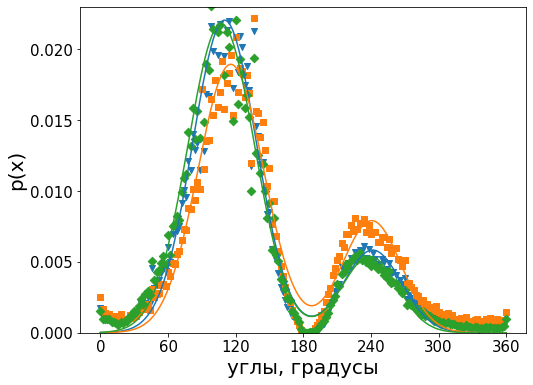

In [45]:
# folder = 'data/'
path = 'data/saved_metadata/'
# path = 'images/saved np/'
# path = 'data/artif_31.01/'

# types_dict = {'Ultra_Co11': 'средние зерна',
#               'Ultra_Co25': 'мелкие зерна',
#               'Ultra_Co8': 'средне-мелкие зерна',
#               'Ultra_Co6_2': 'крупные зерна',
#               'Ultra_Co15': 'средне-мелкие зерна'}


step = 2
width = 8
height = 6
name = '4x_data_border_fix_'
# name = 'artif'
# name = '7_classes_mixer_preprocess'
y_lim = 0.023
# y_lim = 0.013
# y_lim = None
# save = False
save = True
plot_name = '4x_3_grains'

# генерация распределения, аппроксимирование распределения и сохранение данных
angles_approx(path, name, step, width, height, plot_name=plot_name, y_lim=y_lim, save=save, indices=[2,1,4])
# angles_approx(path, name, step, width, height, plot_name=plot_name, y_lim=y_lim, save=save, indices=None)

In [ ]:
def angles_approx(folder, step, width, height, save=False, font_size=20):
    #
    # вывод распределения углов для всех фотографий одного образца
    #

    xy_scatter = np.load(f'{folder}/' + CfgAnglesNames.values + f'{step}.npy', allow_pickle=True)
    xy_gauss = np.load(f'{folder}/' + CfgAnglesNames.approx + f'{step}.npy', allow_pickle=True)
    xy_gauss_data = np.load(f'{folder}/' + CfgAnglesNames.approx_data + f'{step}.npy', allow_pickle=True)
    texts = np.load(f'{folder}/' + CfgAnglesNames.legend + f'{step}.npy', allow_pickle=True)

    synth_angles = np.load(f'{folder}/wc-co.npy')
    synth_angles = np.concatenate([synth_angles, np.zeros((180))])

    plt.rcParams['font.size'] = '15'
    gs = gridspec.GridSpec(1, 1)
    plt.figure(figsize=(width, height))

    ax = plt.subplot(gs[0])
    # маркеры для одновременного вывода скаттера для разных классов
    # количество варкеров=количество классов-1
    markers = ['v', 's', 'D', 'd', 'p', '*']
    for i in range(len(xy_scatter)):
        marker = markers[i]
        ax.plot(xy_gauss[i][0], xy_gauss[i][1])
        ax.scatter(xy_scatter[i][0], xy_scatter[i][1], marker=marker)

    ax.plot(synth_angles[::-1])

    texts = list(texts)
    texts.append('синтетические углы')
    ax.legend(texts, fontsize=14, loc=2)
    plt.ylabel('p(x)', fontsize=font_size)
    plt.xlabel('угол связующего вещества, градусы', fontsize=font_size)
    if save:
        plt.savefig(f'наложение {step}')

    plt.show()

In [ ]:
folder = 'data/saved np/'
step = 5
width = 20
height = 20

# генерация распределения, аппроксимирование распределения и сохранение данных
angles_approx(folder, step, width, height, save=True)

In [ ]:
def angles_approx_modes(folder, step, start1, stop1, start2, stop2, width, height, font_size=25):
    #
    # аппроксимация каждой моды
    #
    xy_scatter_o = np.load(f'{folder}/xy_scatter_step_{step}.npy', allow_pickle=True)
    xy_gauss_o = np.load(f'{folder}/xy_gauss_step_{step}.npy', allow_pickle=True)
    texts = np.load(f'{folder}/texts_step_{step}.npy', allow_pickle=True)

    xy_scatter1 = []
    xy_scatter2 = []

    for j, sc in enumerate(xy_scatter_o):
        x = sc[0]
        y = sc[1]
        xy_scatter1.append([[], []])
        xy_scatter2.append([[], []])
        for i, xi in enumerate(x):
            if xi <= stop1 and xi >= start1:
                xy_scatter1[j][0].append(x[i])
                xy_scatter1[j][1].append(y[i])

            if xi <= stop2 and xi >= start2:
                xy_scatter2[j][0].append(x[i])
                xy_scatter2[j][1].append(y[i])

    plt.rcParams['font.size'] = '25'
    markers = ['v', 's', 'D', 'd', 'p', '*']
    k = 2
    for i in range(len(xy_scatter_o)):
        plt.figure(figsize=(width, height))
        marker = markers[i]

        #    plt.scatter(xy_scatter_o[i][0],xy_scatter_o[i][1])

        x1 = np.array(xy_scatter1[i][0])
        y1 = xy_scatter1[i][1]

        x2 = np.array(xy_scatter2[i][0])
        y2 = xy_scatter2[i][1]

        mu1, sigma1, amp1 = grainApprox.gaussian_fit(x1, y1, mu=120)
        mu2, sigma2, amp2 = grainApprox.gaussian_fit(x2, y2, mu=225)

        x_gauss1 = np.arange(mu1 - 3 * sigma1, mu1 + 3 * sigma1)
        x_gauss2 = np.arange(mu2 - 3 * sigma2, mu2 + 3 * sigma2)

        y_gauss1 = grainStats.gaussian(x_gauss1, mu1, sigma1, amp1)
        y_gauss2 = grainStats.gaussian(x_gauss2, mu2, sigma2, amp2)

        #    plt.plot(x_gauss,y_gauss)
        plt.scatter(x1, y1, marker=marker)
        plt.plot(x_gauss1, y_gauss1)

        plt.scatter(x2, y2, marker=markers[i + 1])
        plt.plot(x_gauss2, y_gauss2)

        #  print('mu1=',mu1,' sigma1=',sigma1,'amp1=',amp1)
        #  print('mu2=',mu2,' sigma2=',sigma2,'amp2=',amp2)
        plt.legend(['moda1', 'moda2', 'approx1', texts[i]], fontsize=14, loc=1)
        plt.ylabel('p(x)', fontsize=font_size)
        plt.xlabel('угол связующего вещества, градусы', fontsize=font_size)
        # plt.ylim([0,max(np.log(xy_scatter[i][1][:-1]))])
    # plt.savefig('крупные моды отдельная аппрокс  ' + names[i])

    #  print(texts)

    #  plt.savefig('распределение углов')
    plt.show()

In [ ]:
folder = 'saved np'
width = 12
height = 15

step = 1

start = 340
stop = 360

start1 = 50
stop1 = 180

start2 = 180
stop2 = 300

angles_approx_modes(folder, step, start1, stop1, start2, stop2, width, height)